In [1]:
import yfinance as yf
import pandas as pd
from pmdarima import auto_arima
import warnings
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
warnings.filterwarnings('ignore')

data = yf.download("AAPL", start="2020-01-01", end="2021-01-01")
data.columns = data.columns.droplevel(1)
data2 = data['Close'].reset_index()
data2

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,Date,Close
0,2020-01-02,72.620834
1,2020-01-03,71.914825
2,2020-01-06,72.487839
3,2020-01-07,72.146957
4,2020-01-08,73.307503
...,...,...
248,2020-12-24,128.737000
249,2020-12-28,133.341339
250,2020-12-29,131.565933
251,2020-12-30,130.444122


## 데이터셋 분리

In [2]:
train = data2[:-7]
test = data2[-7:]

print(len(train))
print(len(test))

246
7


## 최적의 p,d,q 찾기

In [3]:
# auto_arima로 최적의 파라미터 찾기
model = auto_arima(train['Close'], 
                  start_p=0, start_q=0,
                  max_p=5, max_q=5,
                  d=None,  # 자동으로 차분 차수 결정
                  seasonal=False,  # 계절성 없는 경우
                  trace=True,  # 학습 과정 출력
                  error_action='ignore',
                  suppress_warnings=True,
                  stepwise=True)  # 단계적 탐색으로 계산량 감소

# 최적의 파라미터 출력
print("\n최적의 파라미터:")
print(f"p: {model.order[0]}")
print(f"d: {model.order[1]}")
print(f"q: {model.order[2]}")

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1154.221, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1148.020, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1148.911, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1153.970, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1149.413, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1149.457, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1151.399, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1148.513, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.161 seconds

최적의 파라미터:
p: 1
d: 1
q: 0


## Rolloing Forecast

In [4]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon
    end_idx = train_len

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df['Close'][:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df['Close'][:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'AR':
        pred_AR = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df['Close'][:i], order=(1,1,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)

        return pred_AR

In [5]:
import numpy as np

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(train, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(train, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(train, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

test.head()

,Date,Close,pred_mean,pred_last_value,pred_AR
246,2020-12-22,128.649216,91.654744,125.088593,124.823742
247,2020-12-23,127.751732,91.654744,125.088593,124.869543
248,2020-12-24,128.737000,91.654744,125.088593,124.861623
249,2020-12-28,133.341339,91.654744,125.088593,124.862992
250,2020-12-29,131.565933,91.654744,125.088593,124.862755


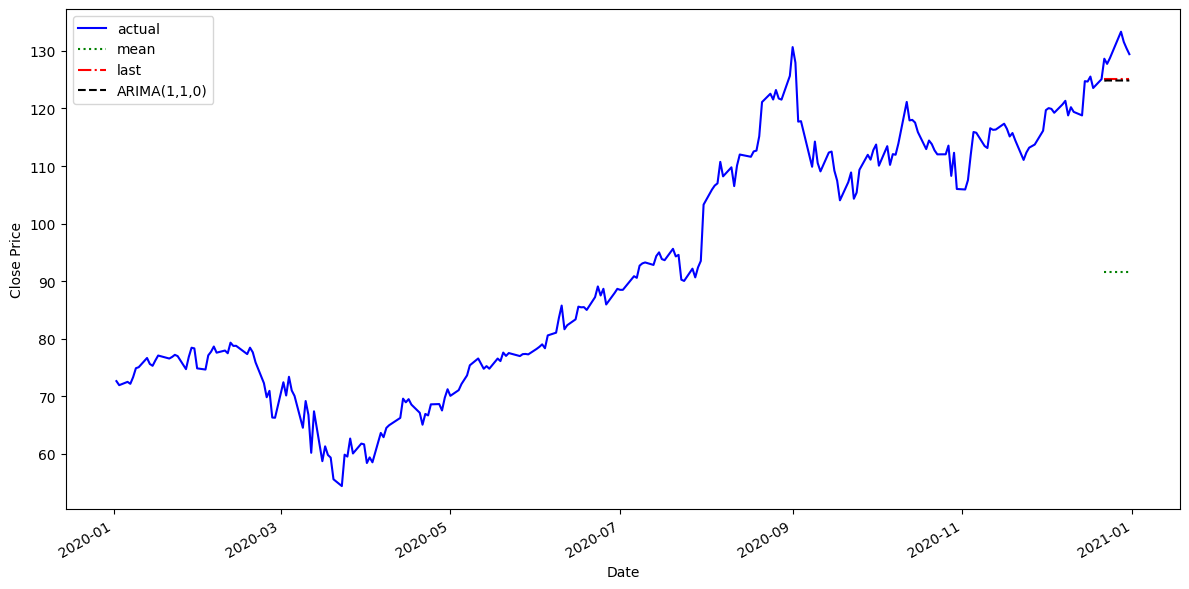

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

# 전체 실제값
ax.plot(data2['Date'], data2['Close'], 'b-', label='actual')

# 테스트 구간 실제값 및 예측값
ax.plot(test['Date'], test['pred_mean'], 'g:', label='mean')
ax.plot(test['Date'], test['pred_last_value'], 'r-.', label='last')
ax.plot(test['Date'], test['pred_AR'], 'k--', label='ARIMA(1,1,0)')

ax.legend(loc='best')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()